learned from: https://github.com/allenday/contextual-bandit/

In [2]:
# %%writefile DataGenerator.py
# learned from: https://github.com/allenday/contextual-bandit/blob/master/contextual_bandit_sim.ipynb
import numpy as np
class DataGenerator():
    """
    Generate bandit data.
    Defaults:
    K = 2 arms
    D = 2 features/arm
    only K arms with fixed features of dimension D too.
    And if you select an arm => it is put into the sample => so why there are many samples when we only have K fixed arms? => what will be put in the sampled results if user select an arm? => isn't it the arm itself and corresponding rewards?
    
    """
    def __init__(self, K = 2, D = 2):
        self.D = D # dimension of the feature vector
        self.K = K # number of bandits
        self.means = np.random.normal(size=self.K)
        self.stds = 1 + 2*np.random.rand(self.K)
        # generate the weight vectors. Initialioze estimate of feature importance for each arm's features
        self.generate_weight_vectors()
    def generate_weight_vectors(self, loc=0.0, scale=1.0):
        self.W = np.random.normal(loc=loc, scale=scale, size=(self.K, self.D))
    
    def generate_samples(self, n = 1000):
        X = np.random.randint(0, 5, size=(n, self.D))

        # The rewards are functions of the inner products of the feature vectors with current weight estimates
        IP = np.dot(X, self.W.T)
        
        # now get the rewards
        R = np.abs(np.random.normal(self.means + IP, self.stds))
        
        return X, R
    
    # Thompson Smapling
    # basic idea: samples from distribution and compares those values for the arms instead
    def thompson_sampling(self, observed_data):
        return np.argmax(np.random.beta(observed_data[:, 0], observed_data[:, 1]))

In [3]:
# %%writefile OnlineVariance.py
#learned from: https://github.com/allenday/contextual-bandit/
#http://stackoverflow.com/questions/5543651/computing-standard-deviation-in-a-stream
import numpy as np
class OnlineVariance(object):
    """
    Welford's algorithm computes the sample variance incrementally
    ddof: delta degree of freedom (used in the divisor: N - ddof) e.g., for the whole population ddof = 0; for sample of elements ddof = 1;
    """
    def __init__(self, iterable=None, ddof = 1):
        self.ddof, self.n, self.mean, self.M2, self.variance = ddof, 0, 0.0, 0.0, 0.0
        if iterable is not None:
            for datum in iterable:
                self.include(datum)
    def include(self, datum):
        self.n += 1
        self.delta = datum - self.mean
        self.mean += self.delta/self.n
        self.M2 += self.delta*(datum - self.mean)
        self.variance = self.M2/(self.n - self.ddof)
    @property
    def std(self):
        return np.sqrt(self.variance)

In [4]:
# %%writefile PositiveStrategy.py
# learned from: https://github.com/allenday/contextual-bandit/
import numpy as np
# from OnlineVariance import OnlineVariance
class PositiveStrategy(object):
    """
    Positive strategy selector.
    Defaults:
    K = 2 arms
    D = 2 features/arm
    epsilon = 0.05 (learning rate/exploration in this case)
    """
    def __init__(self, K = 2, D = 2, epsilon = 0.05):
        self.K = K
        self.D = D
        self.epsilon = epsilon
        
        self.stats = np.empty((K, D), dtype = object)
        
        for k in range(0, K):
            for d in range(0, D):
                self.stats[k, d] = OnlineVariance(ddof = 0)
                
    def mu(self):
        result = np.zeros((self.K, self.D))
        for k in range(0, self.K):
            for d in range(0, self.D):
                result[k, d] = self.stats[k, d].mean
        return result
    
    def sigma(self):
        result = np.zeros((self.K, self.D))
        for k in range(0, self.K):
            for d in range(0, self.D):
                result[k, d] = self.stats[k, d].std
        return result
    
    def include(self, arm, features, value):
        for d in range(0, self.D):
            if features[d] > 0:
                self.stats[arm, d].include(value)
                
    def estimate(self, arm, features):
        # why estimate what is the purpose, this return sum([1, 2, 3]*[1, 3, 2]) = sum([1, 6, 6]) = 13 => so the estimate is the dot product of the features and the arm feature.
        # So there is a context feature and an arm feature
        # OK, sample feature is there, how about arm feature? Where do you get it? And if it is selected => the sample should include the arm feature too?
        # how about time t => at that round => what do you present to the agent?
        return np.sum(features * [val for val in map(lambda x: np.random.normal(x.mean, x.std if x.std > 0 else 1), self.stats[arm])])
    
    def rmse(self, weights):
        # it is the root means squared error of two matrices of size (K, D), between the estimated W and the actual weights.
        return np.sqrt(np.mean((weights-self.mu())**2)/self.K)

In [5]:
import numpy as np
class Simulator(object):
    """
    Simulate model
    epsilon=0.05 learning rate, this is the exploration rate.
    """
    def __init__(self, model, epsilon=0.05):
        self.model = model
        self.K = model.K
        self.D = model.D
        self.epsilon = epsilon

    def simulate(self,features,rewards,weights):
        N = int(rewards.size/self.K)

        regret = np.zeros((N,1)) ## 
        rmse = np.zeros((N,1)) ### root mean square error, so this is the error

        for i in range(0,N):
            F = features[i]
            R = rewards[i]
            
            #known reward and correct choice
            armOptimal = np.argmax(R)
            #estimate the values of the arms and select the armChoice
            armChoice = np.argmax([self.model.estimate(k, F) for k in range(self.K)])
            
            #learn from an arm other than best estimate with p=epsilon
            learn = np.random.uniform() <= self.epsilon
            if learn:
                armAlt = armChoice
                while (armAlt == armChoice):
                    armAlt = int(np.random.uniform() * self.K)
                armChoice = armAlt

            #calculate reward and regret for chosen arm
            armReward = R[armChoice]
            armMaxReward = R[armOptimal]
            print("the max reward is", armMaxReward)
            armRegret = armMaxReward - armReward
            regret[i] = armRegret
            rmse[i]   = self.model.rmse(weights)

            #reward/penalize accordingly
            if armRegret == 0:
                self.model.include(armChoice, F, armReward)
            else:
                self.model.include(armChoice, F, -1 * armRegret)
            
        return regret, rmse

# TEST

In [6]:
%matplotlib inline
import numpy as np
from matplotlib import pylab as plt

In [7]:
num_arms = 3
num_features = 5

# define number of samples and number of choices
num_samples = 1000
num_batches = 100
num_experiments = 2
dg = DataGenerator(num_arms, num_features)

In [8]:
total_regret = []
total_rmse = []
for e in range(0, num_experiments):
    print("experiment: %d" % e)
    positiveStrategy = PositiveStrategy(num_arms, num_features)
    simulator = Simulator(positiveStrategy)
    
    
    previous_rmse = 0.
    for b in range(0, num_batches):
        (sample_features, sample_rewards) = dg.generate_samples(num_samples)
        regret, rmse = simulator.simulate(sample_features, sample_rewards, dg.W)
        
        if previous_rmse == 0:
            initial_rmse = rmse[0][-1]
            previous_rmse = rmse[0][-1]
        if(len(total_rmse) == 0):
            total_rmse = rmse
            total_regret = regret
        else:
            total_rmse += rmse
            total_regret += regret
        
mean_regret = total_regret/num_experiments
mean_rmse = total_rmse/num_experiments


experiment: 0
the max reward is 13.47317443351565
the max reward is 9.893685007324736
the max reward is 3.6331678738136275
the max reward is 11.811522399577894
the max reward is 6.003689995425832
the max reward is 5.03270515929845
the max reward is 11.002668997363633
the max reward is 5.950474201272345
the max reward is 2.034961701549461
the max reward is 11.310638267775065
the max reward is 9.787284402789654
the max reward is 8.841029165053017
the max reward is 3.4351929552422753
the max reward is 12.163709107417313
the max reward is 8.807823694780195
the max reward is 7.001073889304678
the max reward is 7.704964636672664
the max reward is 3.7524007196836093
the max reward is 8.340346893935273
the max reward is 10.579591069788702
the max reward is 9.135875585453597
the max reward is 8.444401685517938
the max reward is 8.488728606959377
the max reward is 6.131304925251211
the max reward is 4.921420929857015
the max reward is 12.32497127943854
the max reward is 8.379592834259721
the max

In [9]:
print(simulator.K) ## k is the number of arms
print(simulator.D) ## D is the number of features
print(simulator.epsilon)
print(len(regret), len(regret[0]))
# print(regret) ### the regret is 1000 x 1 matrix; 1000 means that there are 1000 training samples; 
# print(rmse) ### the rmse is 1000 x 1 matrix; 1000 means that there are 1000 training samples; 
print(len(rmse), len(rmse[0]))

print(positiveStrategy.stats[0,0].mean)
print(positiveStrategy.stats[0,0].n)
print(positiveStrategy.stats[0,1].n)
print(positiveStrategy.stats[0,2].n)



3
5
0.05
1000 1
1000 1
-5.708255880370224
1916
1980
1987


In [10]:
print(dg.W)

[[-0.85077493 -0.35643873 -0.69188163  1.26092479  1.03643467]
 [-1.12812667 -1.34113408 -0.59847863 -0.15600062 -0.94482361]
 [-0.44256861 -1.40309815  0.02343997  1.41976515  1.33764014]]


In [11]:
print(positiveStrategy.mu())

[[-5.70825588 -5.51232228 -5.57023768 -5.41058622 -5.73543289]
 [ 6.48010005  6.92287222  6.00631065  5.46437704  5.97661435]
 [-2.19472959 -3.05306048 -1.39591455 -0.61529658 -1.11501725]]


In [12]:
print(len(sample_rewards))

1000


Text(0.5, 0, 'Round Index')

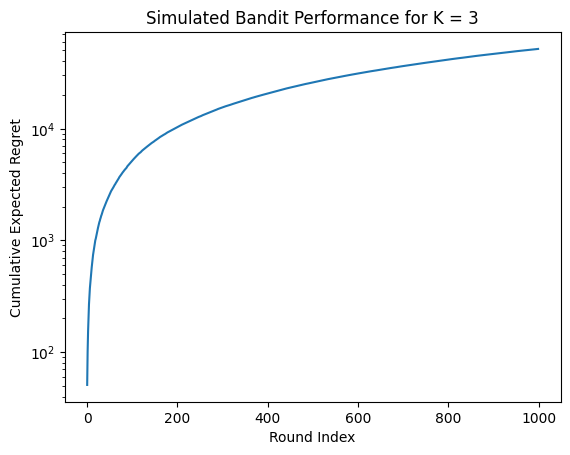

In [13]:
plt.semilogy(np.cumsum(mean_regret)/num_experiments)
plt.title('Simulated Bandit Performance for K = ' + str(num_arms))
plt.ylabel('Cumulative Expected Regret')
plt.xlabel('Round Index')

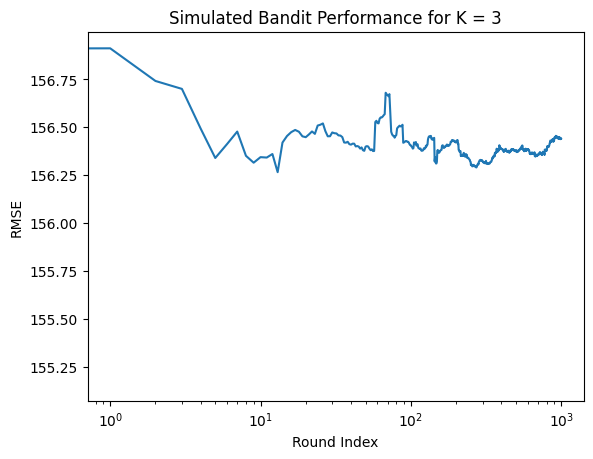

In [14]:
plt.semilogx(mean_rmse/num_experiments)
plt.title('Simulated Bandit Performance for K = ' +str(num_arms))
plt.ylabel('RMSE')
plt.xlabel('Round Index')
plt.show()